In [68]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import preprocessing
#import visuals as vs
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale as scale
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=2)

### Reading data

In [4]:
data = pd.read_csv('fall_detection(1).csv')

In [5]:
data.head()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
0,3,4722.92,4019.64,-1600.00,13,79,317
1,2,4059.12,2191.03,-1146.08,20,54,165
2,2,4773.56,2787.99,-1263.38,46,67,224
3,4,8271.27,9545.98,-2848.93,26,138,554
4,4,7102.16,14148.80,-2381.15,85,120,809


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16382 entries, 0 to 16381
Data columns (total 7 columns):
ACTIVITY       16382 non-null int64
TIME           16382 non-null float64
SL             16382 non-null float64
EEG            16382 non-null float64
BP             16382 non-null int64
HR             16382 non-null int64
CIRCLUATION    16382 non-null int64
dtypes: float64(3), int64(4)
memory usage: 896.0 KB


In [7]:
data.shape

(16382, 7)

In [19]:
data.ACTIVITY.replace([0,1,2,3,4,5],[1,2,3,4,5,6],inplace=True)

In [20]:
set(data)

{'ACTIVITY', 'BP', 'CIRCLUATION', 'EEG', 'HR', 'SL', 'TIME'}

### EDA

In [8]:
data.describe()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
count,16382.000000,16382.000000,1.638200e+04,1.638200e+04,16382.000000,16382.000000,16382.000000
mean,2.361494,10936.842478,7.527198e+04,-5.621125e+03,58.251068,211.536992,2894.341472
std,1.739195,5261.463601,1.275022e+05,1.082209e+05,48.292926,129.949521,3825.927830
min,0.000000,1954.230000,4.222420e+01,-1.262600e+07,0.000000,33.000000,5.000000
25%,0.000000,7263.685000,9.941170e+03,-5.630000e+03,25.000000,119.000000,587.000000
50%,3.000000,9769.355000,3.118920e+04,-3.361275e+03,44.000000,180.000000,1581.000000
75%,4.000000,13481.650000,8.076145e+04,-2.150000e+03,78.000000,271.000000,3539.000000
max,5.000000,50895.500000,2.426140e+06,1.410000e+06,533.000000,986.000000,52210.000000


In [9]:
def Checker(x):
    if type(x) is pd.DataFrame: return 0
    elif type(x) is pd.Series: return 1
    else: return -1
    
def dtype(data):
    what = Checker(data)
    if what == 0:
        dtypes = data.dtypes.astype('str')
        dtypes = dtypes.str.split(r'\d').str[0]
    else:
        dtypes = str(data.dtypes)
        dtypes = re.split(r'\d', dtypes)[0]
    return dtypes

def describe(data):
    '''Provides an overview of your data
        1. dtype    =  Column type
        2. missing% =  % of the column that is missing
        3. nunique  =  Number of unique values in column
        4. top3     =  Top 3 most occuring items
        5. min      =  Minimum value. If not a number column, then empty
        6. mean     =  Average value. If not a number column, then empty
        7. median   =  Middle value. So sort all numbers, and get middle. If not a number column, then empty
        8. max      =  Maximum value. If not a number column, then empty
        9. sample   =  Random 2 elements
        10. name    =  Column Name
    '''
    dtypes = dtype(data)
    length = len(data)
    missing = ((length - data.count())/length*100)
    
    N = [];    most3 = []
    for dt,col in zip(dtypes,data.columns):
        if dt != 'datetime':
            U = data[col].value_counts()
            N.append(len(U))
            if U.values[0] > 1: most3.append(U.index[:3].tolist())
            else: most3.append([]);
        else: N.append(0); most3.append([]);
            
    df = pd.concat([dtypes, missing], 1)
    df.columns = ['dtype','missing%']
    df['nunique'] = N; df['top3'] = most3
    
    numbers = list(data.columns[df['dtype'].isin(('uint','int','float'))])
    df['min'] = data.min()
    df['mean'] = data[numbers].mean()
    df['median'] = data[numbers].median()
    df['max'] = data.max()
    df['sample'] = data.apply(lambda x : x.sample(2).values.tolist())
    df['name'] = list(data.columns)
    return df.sort_values(['missing%', 'nunique', 'dtype'], ascending = [False, False, True]).reset_index(drop = True)

In [11]:
describe(data)

,dtype,missing%,nunique,top3,min,mean,median,max,sample,name
0,float,0.0,16137,"[51.5672, 12220.0, 4132.52]",4.222420e+01,75271.979925,31189.200,2426140.0,"[4218.52, 5273.3]",SL
1,float,0.0,16009,"[10641.6, 13733.8, 14454.5]",1.954230e+03,10936.842478,9769.355,50895.5,"[20385.0, 12872.3]",TIME
2,float,0.0,11225,"[-2650.0, -2070.0, -2710.0]",-1.262600e+07,-5621.125313,-3361.275,1410000.0,"[-13800.0, -2828.0]",EEG
3,int,0.0,2234,"[292, 5, 249]",5.000000e+00,2894.341472,1581.000,52210.0,"[8870.0, 1747.0]",CIRCLUATION
4,int,0.0,652,"[156, 79, 88]",3.300000e+01,211.536992,180.000,986.0,"[247.0, 54.0]",HR
5,int,0.0,341,"[20, 15, 21]",0.000000e+00,58.251068,44.000,533.0,"[25.0, 7.0]",BP
6,int,0.0,6,"[0, 3, 4]",0.000000e+00,2.361494,3.000,5.0,"[3.0, 2.0]",ACTIVITY


In [13]:
data.isnull().sum()

ACTIVITY       0
TIME           0
SL             0
EEG            0
BP             0
HR             0
CIRCLUATION    0
dtype: int64

### PLOTTING

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


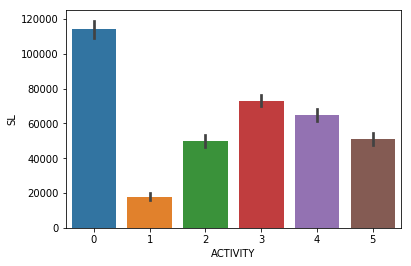

In [12]:
sns.barplot(data = data, x = 'ACTIVITY', y = 'SL')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


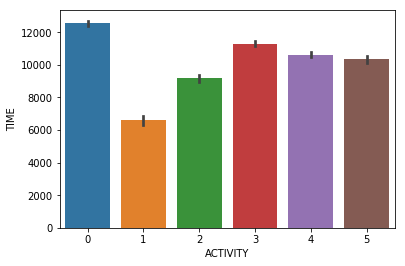

In [8]:
sns.barplot(data = data, x = 'ACTIVITY', y = 'TIME')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


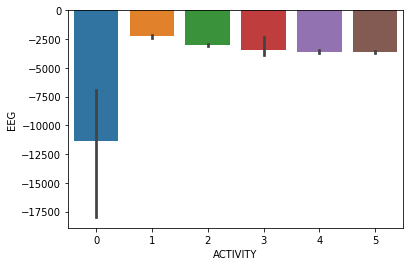

In [9]:
sns.barplot(data = data, x = 'ACTIVITY', y = 'EEG')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


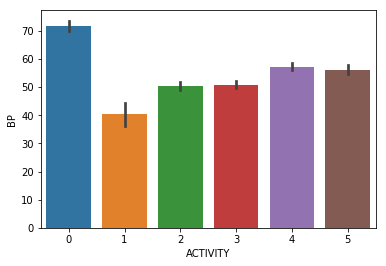

In [10]:
sns.barplot(data = data, x = 'ACTIVITY', y = 'BP')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


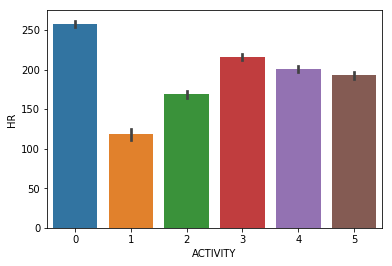

In [11]:
sns.barplot(data = data, x = 'ACTIVITY', y = 'HR')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


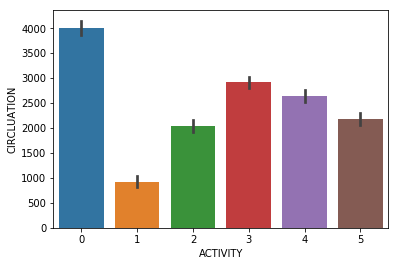

In [12]:
sns.barplot(data = data, x = 'ACTIVITY', y = 'CIRCLUATION')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


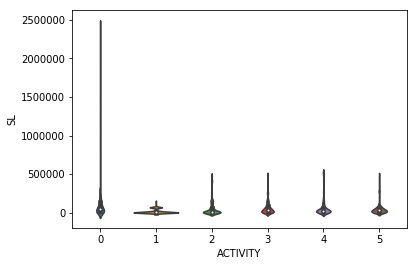

In [13]:
sns.violinplot(data = data, x = 'ACTIVITY', y = 'SL')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


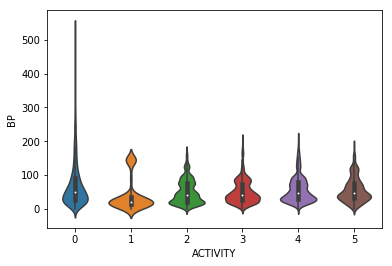

In [14]:
sns.violinplot(data = data, x = 'ACTIVITY', y = 'BP')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


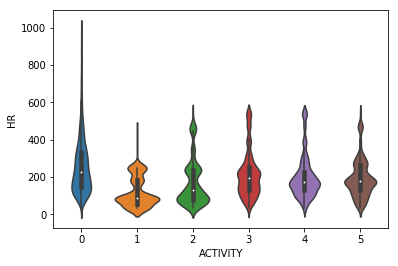

In [15]:
sns.violinplot(data = data, x = 'ACTIVITY', y = 'HR')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


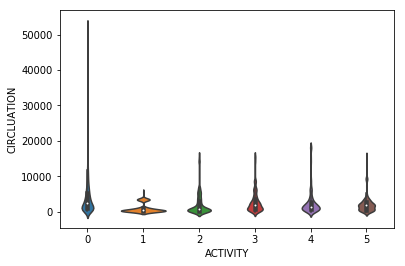

In [16]:
sns.violinplot(data = data, x = 'ACTIVITY', y = 'CIRCLUATION')

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


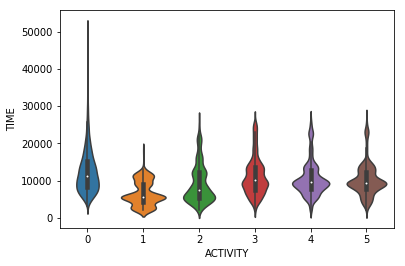

In [17]:
sns.violinplot(data = data, x = 'ACTIVITY', y = 'TIME')

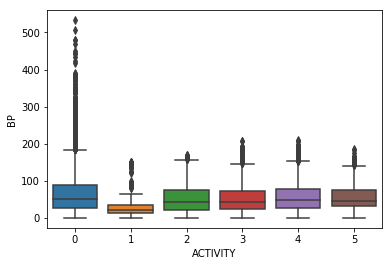

In [18]:
sns.boxplot(data = data, x = 'ACTIVITY', y = 'BP')

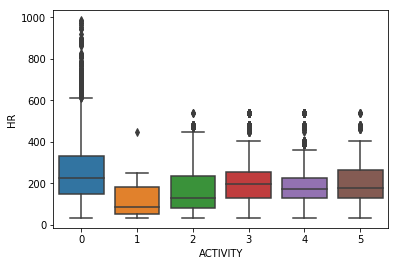

In [19]:
sns.boxplot(data = data, x = 'ACTIVITY', y = 'HR')

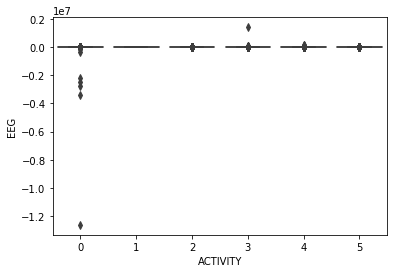

In [20]:
sns.boxplot(data = data, x = 'ACTIVITY', y = 'EEG')

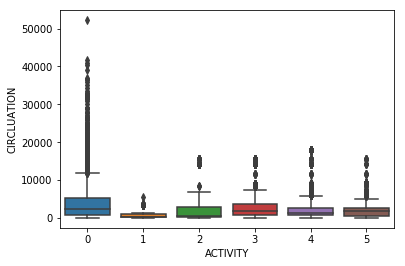

In [21]:
sns.boxplot(data = data, x = 'ACTIVITY', y = 'CIRCLUATION')

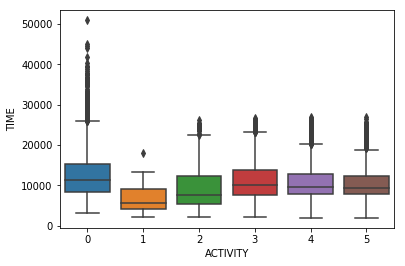

In [22]:
sns.boxplot(data = data, x = 'ACTIVITY', y = 'TIME')

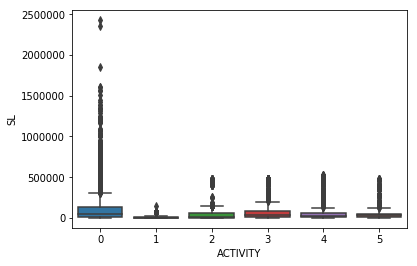

In [23]:
sns.boxplot(data = data, x = 'ACTIVITY', y = 'SL')

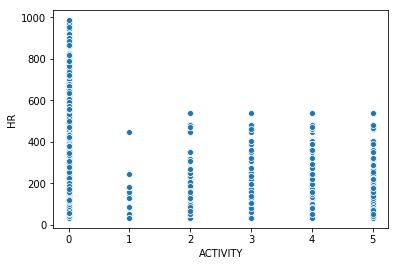

In [24]:
sns.scatterplot(data = data, x = 'ACTIVITY', y = 'HR')

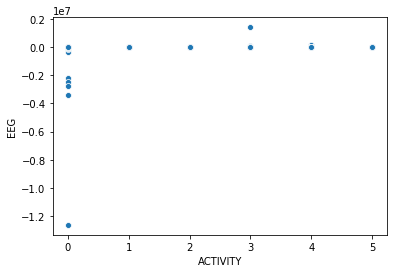

In [25]:
sns.scatterplot(data = data, x = 'ACTIVITY', y = 'EEG')

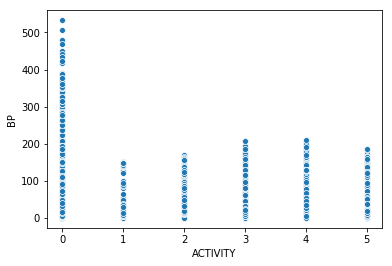

In [26]:
sns.scatterplot(data = data, x = 'ACTIVITY', y = 'BP')

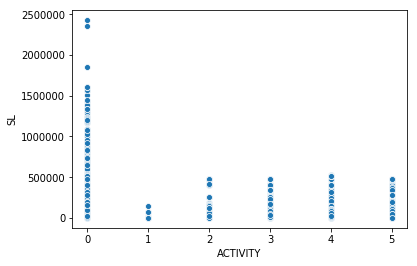

In [27]:
sns.scatterplot(data = data, x = 'ACTIVITY', y = 'SL')

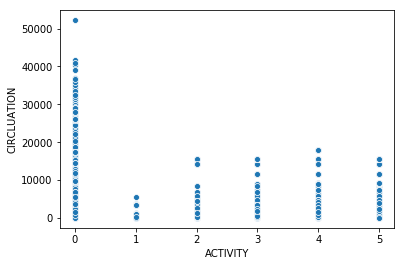

In [28]:
sns.scatterplot(data = data, x = 'ACTIVITY', y = 'CIRCLUATION')

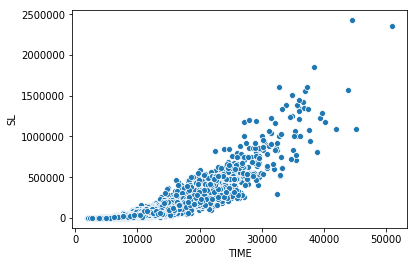

In [99]:
sns.scatterplot(data = data, x = 'TIME', y = 'SL')

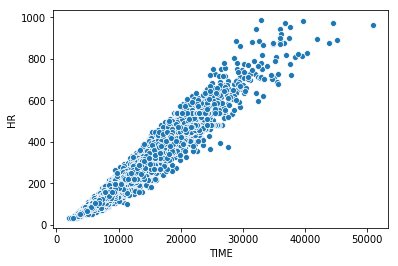

In [100]:
sns.scatterplot(data = data, x = 'TIME', y = 'HR')

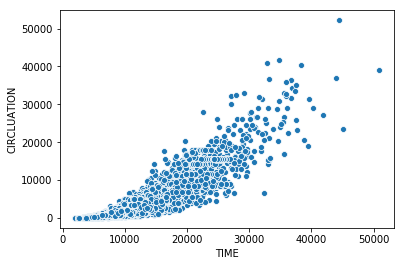

In [101]:
sns.scatterplot(data = data, x = 'TIME', y = 'CIRCLUATION')

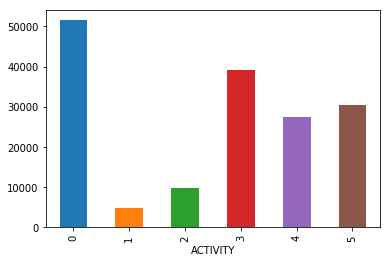

In [102]:
data.groupby('ACTIVITY').SL.median().plot(kind = 'bar')

 Sugar levels are very high for people who are monitored for STANDING and least for people doing WALKING activity.

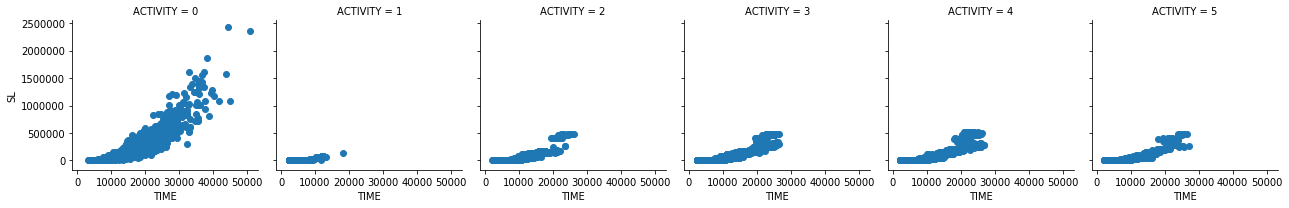

In [15]:
g = sns.FacetGrid(data, col="ACTIVITY") 
g.map(plt.scatter, "TIME", "SL")

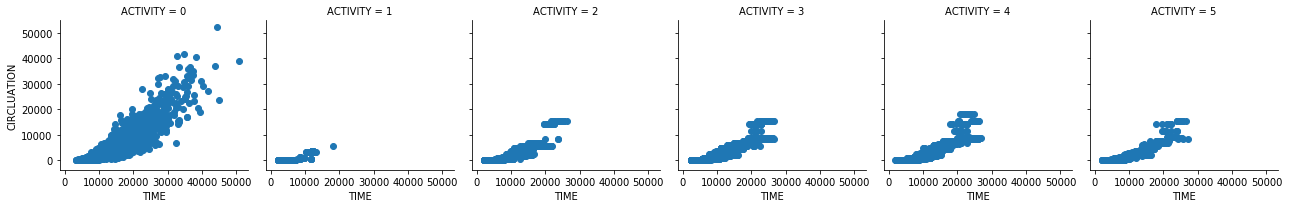

In [16]:
g = sns.FacetGrid(data, col="ACTIVITY") 
g.map(plt.scatter, "TIME", "CIRCLUATION")

In [39]:
data.corr()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
ACTIVITY,1.000000,-0.110405,-0.146789,0.027084,-0.116499,-0.144609,-0.134331
TIME,-0.110405,1.000000,0.843200,-0.048278,0.442334,0.973901,0.876956
SL,-0.146789,0.843200,1.000000,-0.050946,0.401064,0.859408,0.978060
EEG,0.027084,-0.048278,-0.050946,1.000000,-0.049892,-0.050316,-0.050408
BP,-0.116499,0.442334,0.401064,-0.049892,1.000000,0.469164,0.419356
HR,-0.144609,0.973901,0.859408,-0.050316,0.469164,1.000000,0.904160
CIRCLUATION,-0.134331,0.876956,0.978060,-0.050408,0.419356,0.904160,1.000000


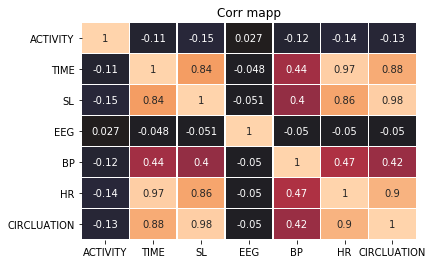

In [40]:
sns.heatmap(data.corr(), annot=True, linewidths=.5, center=0, cbar=False)
plt.title('Corr mapp')
plt.show()

In [44]:
def pairplot(cols_keep):
    g = sns.pairplot(data,vars=cols_keep,kind='scatter',hue='ACTIVITY')
    return

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\ASHISH\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


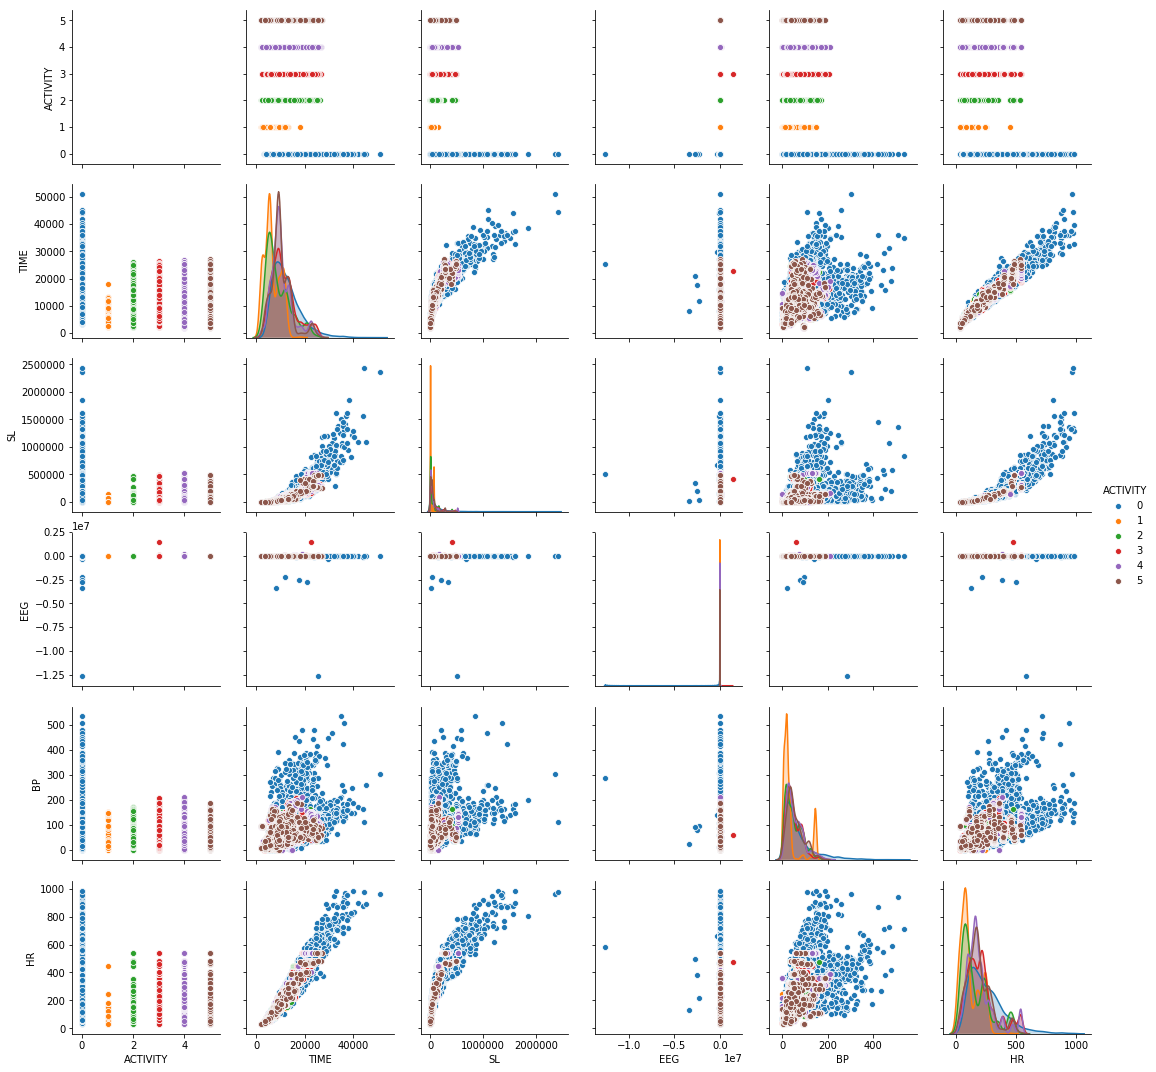

In [46]:
cols_keep = list(data.columns[0:6])
pairplot(cols_keep)

## The dependent variable is ACTIVITY and it takes the following values
### 0- Standing
### 1- Walking 
### 2- Sitting 
### 3- Falling
### 4- Cramps 
### 5- Running


### count of each activity

In [22]:
data["ACTIVITY"].value_counts()  

1    4608
4    3588
5    3494
3    2502
6    1688
2     502
Name: ACTIVITY, dtype: int64

In [76]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
count,16382.000000,16382.000000,1.638200e+04,1.638200e+04,16382.000000,16382.000000,16382.000000
mean,2.361494,10936.842478,7.527198e+04,-5.621125e+03,58.251068,211.536992,2894.341472
std,1.739195,5261.463601,1.275022e+05,1.082209e+05,48.292926,129.949521,3825.927830
min,0.000000,1954.230000,4.222420e+01,-1.262600e+07,0.000000,33.000000,5.000000
25%,0.000000,7263.685000,9.941170e+03,-5.630000e+03,25.000000,119.000000,587.000000
50%,3.000000,9769.355000,3.118920e+04,-3.361275e+03,44.000000,180.000000,1581.000000
75%,4.000000,13481.650000,8.076145e+04,-2.150000e+03,78.000000,271.000000,3539.000000
90%,5.000000,18363.400000,1.803541e+05,-1.169946e+03,116.000000,393.900000,6746.000000
95%,5.000000,21955.760000,3.093476e+05,-8.391564e+02,148.000000,482.950000,10237.900000
99%,5.000000,25887.848000,5.214147e+05,-2.368100e+02,245.000000,585.190000,18067.000000


### OUTLIERS treament

In [26]:
col=[]
for i in data.columns:
    if data[i].dtype!='object':
        col.append(i)
        
col

['ACTIVITY', 'TIME', 'SL', 'EEG', 'BP', 'HR', 'CIRCLUATION']

In [28]:
for k in col:
    IQR=np.percentile(data[k],75)-np.percentile(data[k],25)
    Outlier_top=np.percentile(data[i],75)+1.5*IQR
    Outlier_bottom=np.percentile(data[k],25)-1.5*IQR
    data[k]=np.where(data[k] >Outlier_top,Outlier_top,data[k])
    data[k]=np.where(data[k]<Outlier_bottom,Outlier_bottom,data[k])

TypeError: 'numpy.float64' object is not iterable

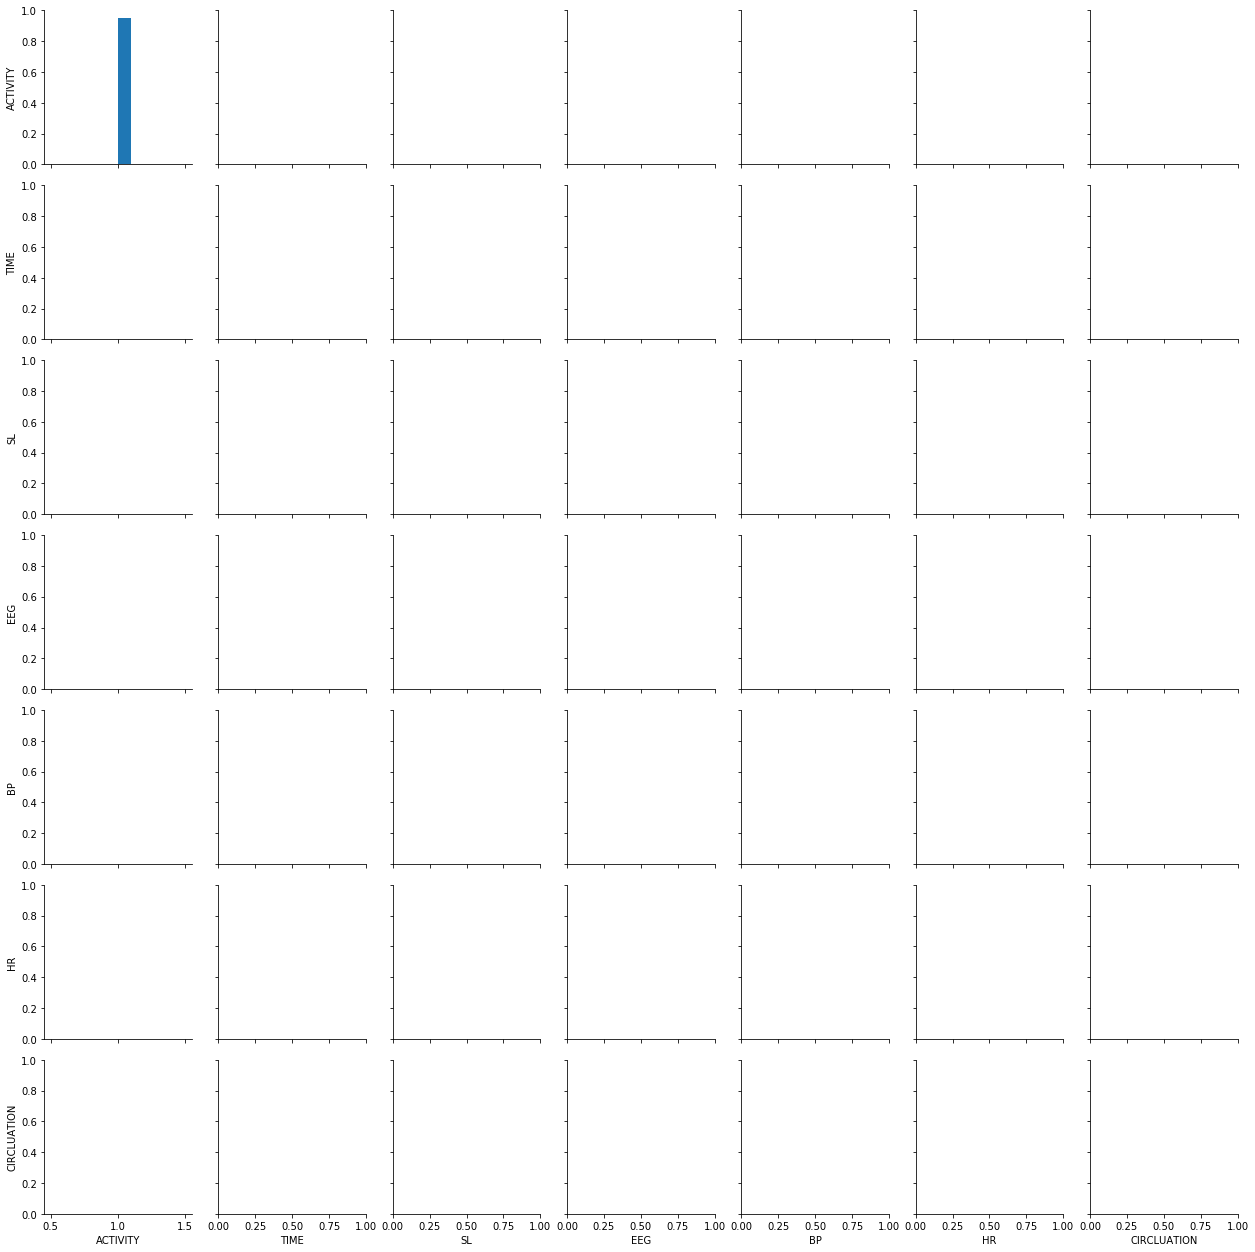

In [29]:
g = sns.PairGrid(data, hue="ACTIVITY")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

C:\Users\ASHISH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\ASHISH\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


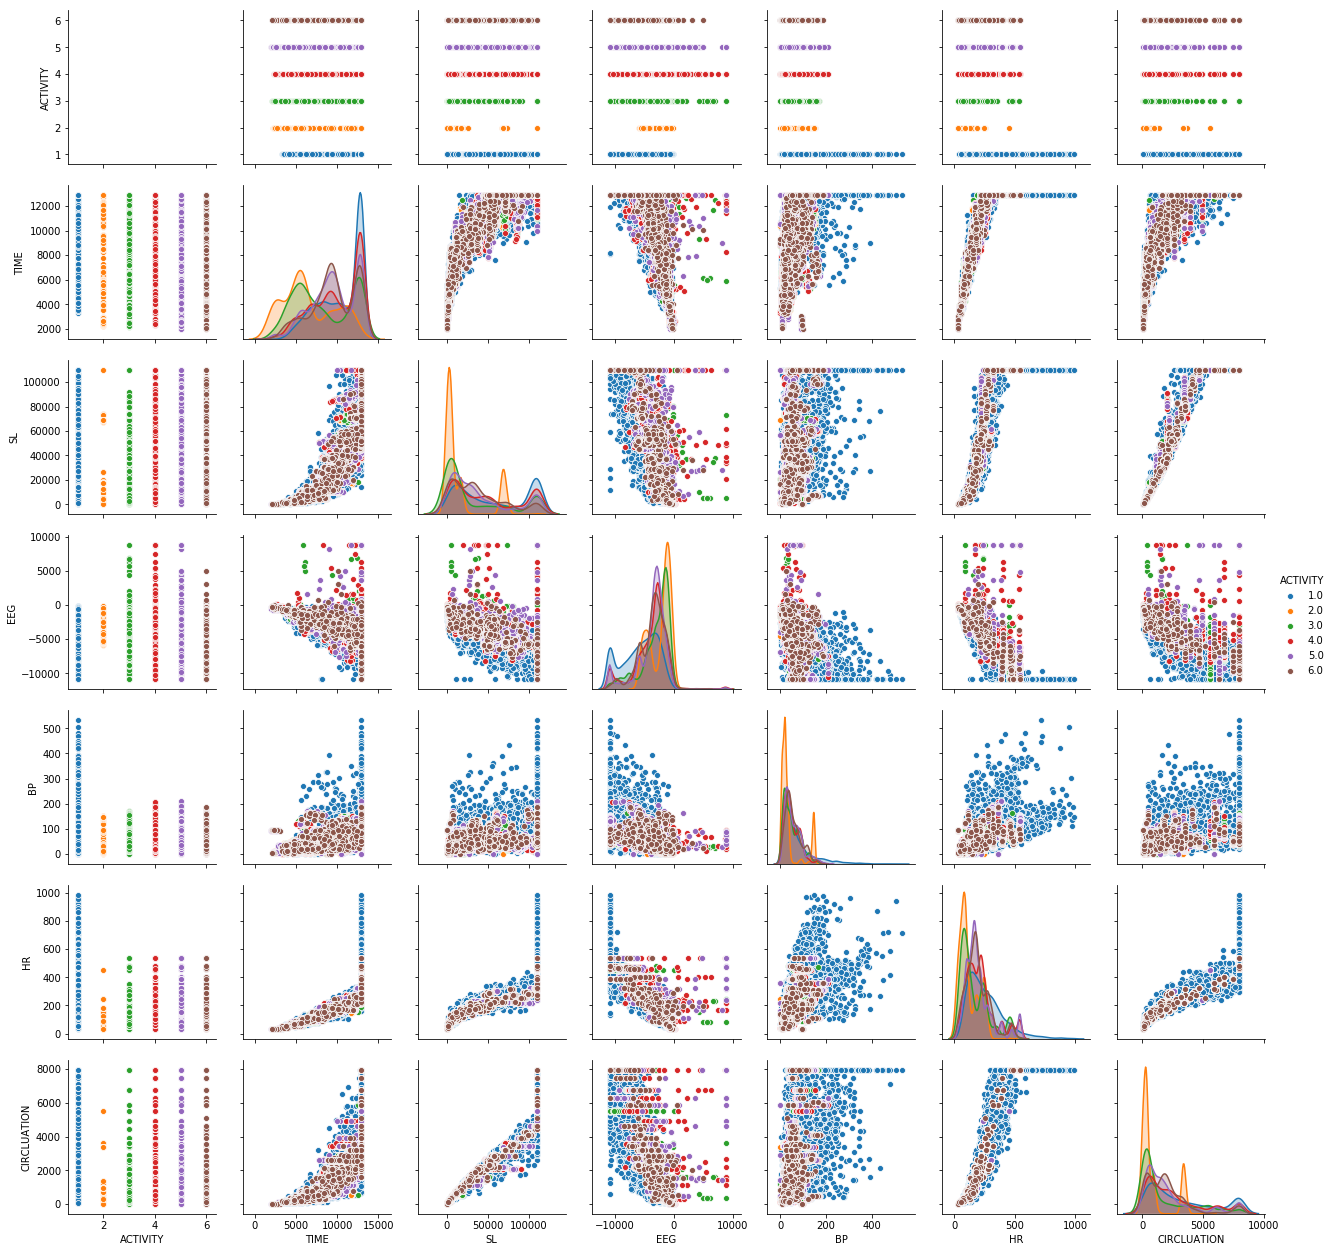

In [30]:
sns.pairplot(data,diag_kind = 'kde', hue="ACTIVITY")

In [31]:
def clean(data, missing = 'mean', remove_id = True):
    '''Cleans entire dataset.
    1. missing =
        mean, max, median, min
        Fills all missing values with column mean/median etc

    2. remove_id = True/False
        Checks data to see if theres an ID column.
        Removes it (not perfect)
    '''
    x = data[data.columns[dtype(data) != 'object']].copy()
    for c in x.columns[x.count()!=len(x)]:
        x[c] = eval('x[c].fillna(x[c].{}())'.format(missing))
    if remove_id:
        for c in x.columns[(dtype(x) == 'int')|(dtype(x) == 'uint')]:
            if x[c].min() >= 0:
                j = (x[c] - x[c].min()).sort_values().diff().sum()
                if j <= 1.001*len(x) and j >= len(x)-1: x.pop(c);
    return x

In [32]:
data = clean(data)

In [33]:
data.head()

,ACTIVITY,TIME,SL,EEG,BP,HR,CIRCLUATION
0,4.0,4722.92,4019.64,-1600.00,13.0,79.0,317.0
1,3.0,4059.12,2191.03,-1146.08,20.0,54.0,165.0
2,3.0,4773.56,2787.99,-1263.38,46.0,67.0,224.0
3,5.0,8271.27,9545.98,-2848.93,26.0,138.0,554.0
4,5.0,7102.16,14148.80,-2381.15,85.0,120.0,809.0


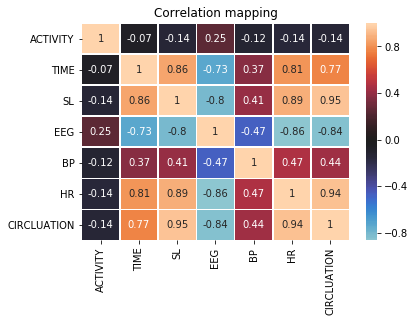

In [35]:
sns.heatmap(data.corr(), annot=True, linewidths=.5, center=0, cbar=True)
plt.title('Correlation mapping')
plt.show()

In [36]:
def exclude(data, col):
    '''Only returns a dataframe where the columns in col are not included'''
    if type(col) is str: col = [col]
    columns = list(data.columns)
    leave = list(set(columns) - set(col))
    return data[leave]

In [39]:
Y = data['ACTIVITY']
X = exclude(data, 'ACTIVITY')

In [40]:
Y.shape, X.shape

((16382,), (16382, 6))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11467, 6), (4915, 6), (11467,), (4915,))

### run 1st train

In [46]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:932: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:932: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\ASHISH\Anacond

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ACTIVITY   No. Observations:                11467
Model:                            GLM   Df Residuals:                    11460
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 12 Jan 2019   Deviance:                          nan
Time:                        13:05:00   Pearson chi2:                 4.47e+20
No. Iterations:                   100   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        7.917e+17      3e+06   2.64e+11      0.000    7.92e+17    7.92e+17
HR          -5.019e+14   1.72e+04  -2.91e+10      0.000   -5.02e+14   -5.02e+14
CIRCLUATION  1.818e+14   1292.347   1.41e+11      0.000    1.82e+14    1.82e+14
TIME         9.768e+13    498.269   1.96e+11      0.000    9.77e+13    9.77e+13
SL          -1.008e+13     67.965  -1.48e+11      0.000   -1.01e+13   -1.01e+13
EEG          1.357e+14    432.836   3.13e+11      0.000    1.36e+14    1.36e+14
BP           -1.06e+14   1.51e+04  -7.02e+09      0.000   -1.06e+14   -1.06e+14
===============================================================================
"""

In [49]:
logreg = LogisticRegression()
rfe = RFE(logreg, 4)             # run RFE with 6 var as output
rfe = rfe.fit(X,Y)
print(rfe.support_)           # Print the boolean results
print(rfe.ranking_)           #print ranking

C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

[ True False  True False  True  True]
[1 2 1 3 1 1]


In [50]:
col = ['TIME', 'BP', 'EEG', 'HR']    # Variables selected by RFE 

In [51]:
logsk = LogisticRegression(C=1e9)
logsk.fit(X_train[col], y_train)

C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [52]:
#Comparing the model with StatsModels
logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:932: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\ASHISH\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:932: RuntimeWarning: invalid value encountered in add
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\ASHISH\Anaconda

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ACTIVITY   No. Observations:                11467
Model:                            GLM   Df Residuals:                    11462
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 12 Jan 2019   Deviance:                          nan
Time:                        13:07:57   Pearson chi2:                 4.47e+20
No. Iterations:                   100   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.805e+17   2.39e+06   4.11e+11      0.000    9.81e+17    9.81e+17
TIME        4.709e+13    360.074   1.31e+11      0.000    4.71e+13    4.71e+13
BP         -1.235e+14   1.51e+04  -8.18e+09      0.000   -1.24e+14   -1.24e+14
EEG         1.315e+14    427.932   3.07e+11      0.000    1.31e+14    1.31e+14
HR          7.781e+14   1.12e+04   6.95e+10      0.000    7.78e+14    7.78e+14
==============================================================================
"""

### Predictions

In [53]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test[col])

In [55]:
# Converting y_pred to a dataframe which is an array
cols = ["Standing", "Walking", "Sitting", "Falling", "Cramps", "Running"]
y_pred_data = pd.DataFrame(y_pred, columns = cols)
y_pred_data.head()

,Standing,Walking,Sitting,Falling,Cramps,Running
0,0.182761,0.080512,0.180212,0.183923,0.212370,0.160222
1,0.273229,0.011964,0.149611,0.191629,0.265380,0.108186
2,0.194113,0.042599,0.202570,0.141273,0.268207,0.151239
3,0.226318,0.019932,0.169944,0.187410,0.270113,0.126283
4,0.155773,0.056840,0.190101,0.199442,0.240254,0.157591


In [56]:
y_pred_data['pred_Standing'] = y_pred_data.Standing.map( lambda x: 1 if x > 0.5 else 0)
y_pred_data['pred_Walking'] = y_pred_data.Walking.map( lambda x: 2 if x > 0.5 else 0)
y_pred_data['pred_Sitting'] = y_pred_data.Sitting.map( lambda x: 3 if x > 0.5 else 0)
y_pred_data['pred_Falling'] = y_pred_data.Falling.map( lambda x: 4 if x > 0.5 else 0)
y_pred_data['pred_Cramps'] = y_pred_data.Cramps.map( lambda x: 5 if x > 0.5 else 0)
y_pred_data['pred_Running'] = y_pred_data.Running.map( lambda x: 6 if x > 0.5 else 0)
y_pred_data.head()

,Standing,Walking,Sitting,Falling,Cramps,Running,pred_Standing,pred_Walking,pred_Sitting,pred_Falling,pred_Cramps,pred_Running
0,0.182761,0.080512,0.180212,0.183923,0.212370,0.160222,0,0,0,0,0,0
1,0.273229,0.011964,0.149611,0.191629,0.265380,0.108186,0,0,0,0,0,0
2,0.194113,0.042599,0.202570,0.141273,0.268207,0.151239,0,0,0,0,0,0
3,0.226318,0.019932,0.169944,0.187410,0.270113,0.126283,0,0,0,0,0,0
4,0.155773,0.056840,0.190101,0.199442,0.240254,0.157591,0,0,0,0,0,0


### PCA analysis

In [57]:
X_train.shape

(11467, 6)

In [58]:
pca = PCA(svd_solver='randomized', random_state=42)

In [59]:
pca.fit(X_train)  #pcs fit on train

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [60]:
pca.components_

array([[ 2.88181517e-03,  5.68614184e-02,  6.37080889e-02,
         9.94706362e-01, -5.70856586e-02,  4.85036744e-04],
       [-1.96170452e-02, -1.58339021e-01, -2.74467302e-01,
         8.09109053e-02,  9.44790792e-01, -5.95075604e-03],
       [-1.63142997e-03, -2.44089772e-01,  9.40271720e-01,
        -3.27759994e-02,  2.35012627e-01, -1.18849361e-03],
       [ 4.97333071e-02,  9.53661145e-01,  1.90560176e-01,
        -5.41896416e-02,  2.20884194e-01,  4.18262052e-03],
       [ 3.48052039e-01, -2.27710307e-02, -5.97973202e-03,
         6.50920265e-04,  7.52023454e-03,  9.37149147e-01],
       [ 9.35943685e-01, -4.61261108e-02, -1.22120326e-02,
         1.21340336e-03,  5.85418361e-03, -3.48850860e-01]])

In [61]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC_1':pca.components_[0],'PC_2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC_1,PC_2,Feature
0,0.002882,-0.019617,HR
1,0.056861,-0.158339,CIRCLUATION
2,0.063708,-0.274467,TIME
3,0.994706,0.080911,SL
4,-0.057086,0.944791,EEG


In [64]:
pca.explained_variance_ratio_

array([9.96350732e-01, 1.98869267e-03, 1.41296535e-03, 2.45730273e-04,
       1.10507794e-06, 7.74990374e-07])

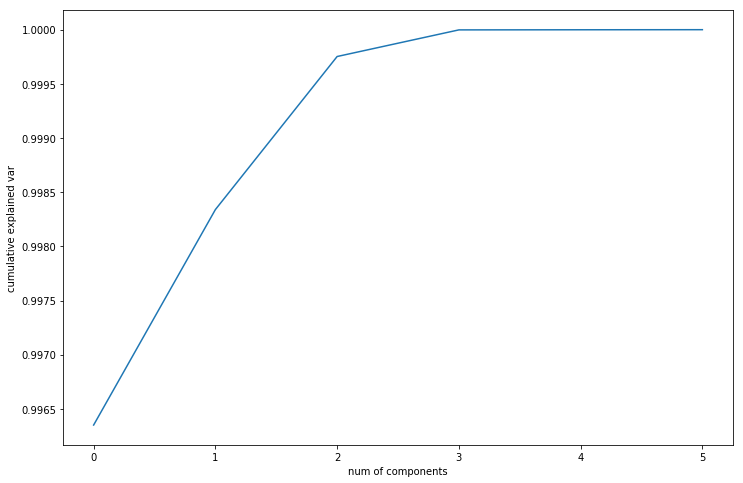

In [66]:
#screenplot
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('num of components')
plt.ylabel('cumulative explained var')
plt.show()

above graph is looking like the 2 components are enough to describe 99.95% of the variance in the dataset
will choose 2 components for modeling

TypeError: 'PCA' object is not subscriptable

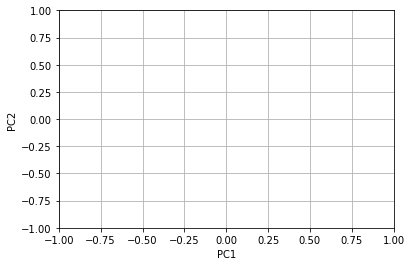

In [85]:
pca = PCA()
x_new = pca.fit(X_train)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [83]:
#Use incremental PCA for efficiency 
pca_final = IncrementalPCA(n_components=2)

In [71]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(11467, 2)

In [72]:
corrmat = np.corrcoef(df_train_pca.transpose())  #correlation matrix

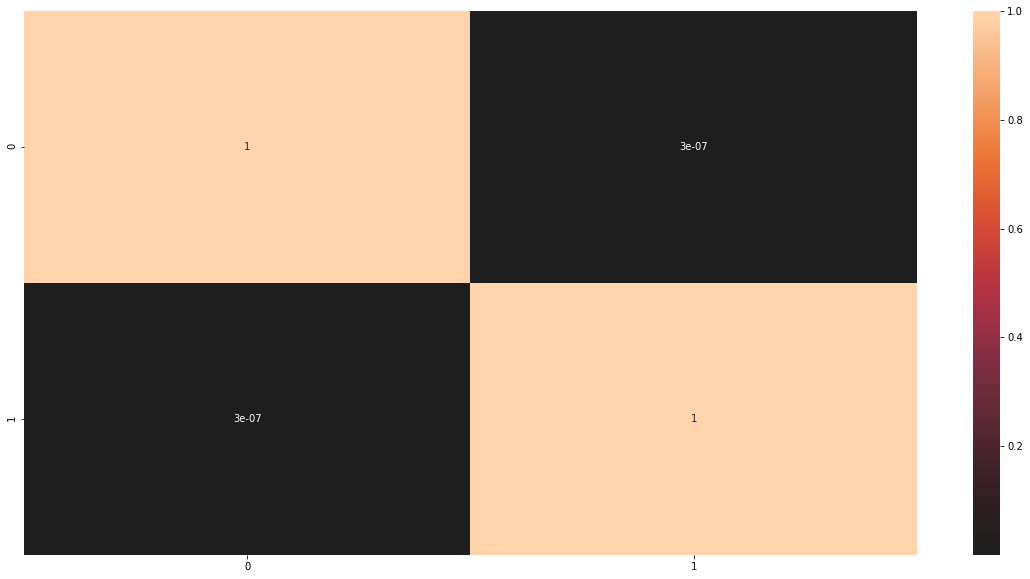

In [87]:
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True,center = 0)

In [76]:
#Apply selected components to test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(4915, 2)

In [78]:
#training model on train
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [88]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
pred_probs_test

array([0.09292599, 0.016015  , 0.06384468, ..., 0.03844671, 0.04947087,
       0.02446147])

In [93]:
DTClassifier = DecisionTreeClassifier (criterion='gini', max_depth=3, min_samples_split = 3)
DTClassifier.fit (X_train,Y_train)
predicted_labels2 = DTClassifier.predict(X_test)
accuracyscore2 = accuracy_score(Y_test1, predicted_labels2)
print("accuracy = ", accuracyscore2*100.0)
print(confusion_matrix(Y_Test, predicted_labels2))
print(classification_report(Y_test, predicted_labels2))

NameError: name 'Y_train' is not defined

In [91]:
DTClassifier = DecisionTreeClassifier (criterion='entropy', max_depth=3, min_samples_split = 3)
DTClassifier.fit (X_Train,Y_Train)
predicted_labels1 = DTClassifier.predict(X_Test)
accuracyscore1 = accuracy_score(Y_Test, predicted_labels1)
print("accuracy = ", accuracyscore1*100.0)
print(confusion_matrix(Y_Test, predicted_labels1))
print(classification_report(Y_Test, predicted_labels1))

NameError: name 'X_Train' is not defined

In [95]:
pdist
#help(pdist)
d_euc = pdist(data.iloc[:,2:7], metric = "euclidean")
#Building the cluster

#help(linkage)
clus1 = linkage(d_euc, method = "average")
#Displaying the clusters in Dendrogram

dendrogram(clus1, labels = data_df[["Region"]].values.tolist())
plt.xlabel("hclust")
plt.ylabel("Channel")
plt.suptitle("Cluster Dendrogram", fontweight = 'bold', fontsize =14)

NameError: name 'data_df' is not defined